# Metagenomic Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/bacterial genomes/')

# Shotgun LM

In [5]:
classification_df = pd.read_csv(path/'s16_shotgun_sequences.csv')

In [6]:
classification_df.head()

,Sequence,Species,set
0,TTAATACTCTGCTACTGTGACGTTACTCGCAGAAGAAGCACCGGCT...,Gammaproteobacteria Alteromonadales Moritellac...,train
1,CTGCATGGCTGTCGCCAGCTCGTGTTGTGAAATGTTGGGTTAAGTC...,Gammaproteobacteria Alteromonadales Moritellac...,train
2,TACAATGGCGCATACAAAGGGCTGCAAACCAGCAATGGTAAGCGAA...,Gammaproteobacteria Alteromonadales Moritellac...,train
3,TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATACCGC...,Gammaproteobacteria Alteromonadales Moritellac...,train
4,AAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTT...,Gammaproteobacteria Alteromonadales Moritellac...,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((23493, 3), (1771, 3), (1954, 3))

In [9]:
voc = np.load(path/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [10]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [11]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=10000, text_cols='Sequence', label_cols='Species', vocab=model_vocab)

In [14]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.7

In [15]:
learn = get_model_LM(data, drop_mult, config)

In [16]:
learn.load('b2');

In [17]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


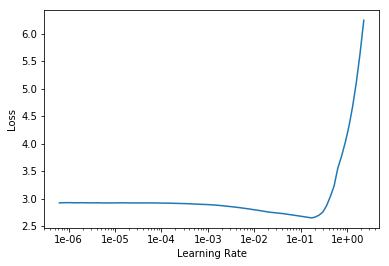

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.610615,2.311230,0.313769,00:32
1,2.369260,2.058330,0.395895,00:32
2,2.154980,1.878148,0.454244,00:32
3,1.982165,1.757349,0.492219,00:32
4,1.851190,1.677147,0.518861,00:32
5,1.752664,1.624630,0.537067,00:32
6,1.676555,1.586311,0.547210,00:32
7,1.619388,1.574331,0.559185,00:32
8,1.576945,1.547122,0.564130,00:32
9,1.544694,1.537301,0.568294,00:32


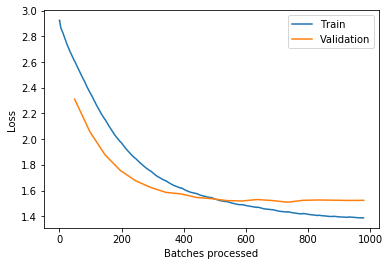

In [23]:
learn.recorder.plot_losses()

In [24]:
learn.save('s16_sg_LM')
learn.save_encoder('s16_sg_LM_enc')

# Classification

In [5]:
classification_df = pd.read_csv(path/'s16_shotgun_sequences.csv')

In [6]:
classification_df.head()

,Sequence,Species,set
0,TTAATACTCTGCTACTGTGACGTTACTCGCAGAAGAAGCACCGGCT...,Gammaproteobacteria Alteromonadales Moritellac...,train
1,CTGCATGGCTGTCGCCAGCTCGTGTTGTGAAATGTTGGGTTAAGTC...,Gammaproteobacteria Alteromonadales Moritellac...,train
2,TACAATGGCGCATACAAAGGGCTGCAAACCAGCAATGGTAAGCGAA...,Gammaproteobacteria Alteromonadales Moritellac...,train
3,TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATACCGC...,Gammaproteobacteria Alteromonadales Moritellac...,train
4,AAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTT...,Gammaproteobacteria Alteromonadales Moritellac...,train


In [8]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [9]:
voc = np.load(path/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [10]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df,
                                             tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=800)

In [13]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [14]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [15]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.

In [16]:
learn.load_encoder('s16_sg_LM_enc')
learn.freeze()

In [17]:
learn = learn.to_fp16(dynamic=True);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


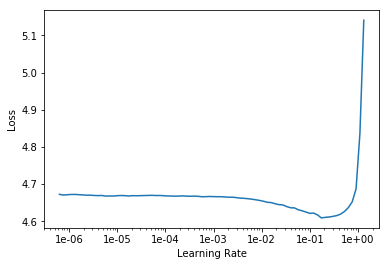

In [19]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(10, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.583937,4.485982,0.015810,00:15
1,4.153259,3.706589,0.094297,00:15
2,3.855326,3.027178,0.181818,00:15
3,3.622711,2.732111,0.234896,00:15
4,3.440989,2.582093,0.256352,00:15
5,3.282553,2.426014,0.284585,00:15
6,3.156684,2.312452,0.316206,00:15
7,3.044935,2.205714,0.356861,00:15
8,2.947203,2.155378,0.374365,00:15
9,2.874098,2.141256,0.373800,00:15


In [30]:
learn.freeze_to(-2)
learn.fit_one_cycle(8, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.767025,2.072083,0.391304,00:18
1,2.628174,1.835360,0.446076,00:18
2,2.423244,1.565752,0.512140,00:18
3,2.207998,1.380441,0.553924,00:18
4,2.009198,1.244732,0.610954,00:18
5,1.834939,1.164982,0.630717,00:18
6,1.699807,1.129356,0.646527,00:18
7,1.611505,1.123778,0.642575,00:18


In [31]:
learn.freeze_to(-3)
learn.fit_one_cycle(8, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.488821,1.107427,0.652174,00:28
1,1.460613,1.060514,0.657820,00:28
2,1.409081,0.989456,0.677019,00:28
3,1.338182,0.922066,0.693958,00:28
4,1.263544,0.877941,0.715980,00:28
5,1.195983,0.848933,0.723320,00:28
6,1.153015,0.837112,0.729531,00:28
7,1.112185,0.835261,0.727273,00:28


In [32]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.069019,0.826691,0.727273,00:34
1,1.055315,0.803494,0.732919,00:34
2,1.027576,0.776369,0.738566,00:34
3,0.995695,0.744205,0.750988,00:34
4,0.947850,0.716072,0.756070,00:34
5,0.900485,0.701097,0.764540,00:34
6,0.863659,0.690870,0.770186,00:34
7,0.838598,0.692249,0.767363,00:34


In [33]:
learn.fit_one_cycle(12, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.804661,0.685899,0.773574,00:33
1,0.802283,0.671564,0.774704,00:34
2,0.794626,0.667520,0.773574,00:34
3,0.781659,0.649187,0.779785,00:34
4,0.757071,0.630175,0.797290,00:34
5,0.724553,0.619240,0.795031,00:34
6,0.693499,0.600313,0.802372,00:34
7,0.668135,0.593810,0.802936,00:34
8,0.644158,0.581629,0.802936,00:34
9,0.618349,0.579420,0.809712,00:34


In [34]:
learn.fit_one_cycle(12, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.581657,0.573713,0.809712,00:33
1,0.574872,0.572716,0.811406,00:33
2,0.576192,0.571268,0.812535,00:34
3,0.570046,0.566902,0.814794,00:34
4,0.566589,0.562308,0.817052,00:34
5,0.560064,0.562861,0.814794,00:34
6,0.557733,0.561793,0.818182,00:34
7,0.552027,0.559644,0.815359,00:34
8,0.541012,0.559375,0.816488,00:34
9,0.539841,0.556562,0.815923,00:34


In [35]:
learn.fit_one_cycle(12, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.527213,0.556740,0.818182,00:33
1,0.533137,0.556504,0.818182,00:33
2,0.536752,0.552650,0.818182,00:33
3,0.532766,0.552673,0.818182,00:33
4,0.527088,0.549748,0.819876,00:34
5,0.523492,0.545109,0.821005,00:34
6,0.521866,0.540934,0.824393,00:34
7,0.517509,0.540542,0.823828,00:34
8,0.513404,0.540786,0.826652,00:34
9,0.503302,0.539057,0.825522,00:34


In [36]:
learn.save('metagenomic_sg_genus_finetune')

In [15]:
learn.load('metagenomic_sg_genus_finetune');

In [16]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=800)
learn.data = data_clas

In [17]:
preds = learn.get_preds()

In [18]:
p = torch.argmax(preds[0], dim=1)

In [19]:
p

tensor([34, 19, 87,  ..., 85, 65, 61])

In [20]:
(p == preds[1]).float().mean()

tensor(0.8076)

In [21]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [22]:
precision_score(preds[1], p, average='macro')

0.8102115794064945

In [23]:
recall_score(preds[1], p, average='macro')

0.8054483937649672

In [24]:
accuracy_score(preds[1], p)

0.8075742067553736

In [25]:
f1_score(preds[1], p, average='macro')

0.8044911375857908

In [74]:
pred_df = pd.DataFrame(preds[1], columns=['gt_int'])

In [75]:
pred_df['gt_name'] = pred_df.gt_int.map(lambda x: data_clas.classes[x])

In [76]:
pred_df['predicted_int'] = p
pred_df['predicted_name'] = pred_df.predicted_int.map(lambda x: data_clas.classes[x])

In [77]:
pred_df.gt_name.iloc[25]

'Gammaproteobacteria Oceanospirillales Oceanospirillales_incertae_sedis Salicola'

In [66]:
pred_df[pred_df.gt_name.map(lambda x: len(x.split())) == 3].gt_name[32].split('_', 1)

['Gammaproteobacteria Gammaproteobacteria', 'incertae_sedis Simiduia']

In [79]:
pred_df.gt_name = pred_df.gt_name.map(lambda x: ' '.join(x.split('_', 1)) if len(x.split()) == 3 else x)

In [80]:
pred_df.predicted_name = pred_df.predicted_name.map(lambda x: ' '.join(x.split('_', 1)) if len(x.split()) == 3 else x)

In [88]:
(pred_df.gt_name.map(lambda x: x.split()[3]) == pred_df.predicted_name.map(lambda x: x.split()[3])).mean()

0.8075742067553736

In [89]:
taxa_list = ['Phylum', 'Class', 'Order', 'Genus']
for i, taxa in enumerate(taxa_list):
    print(taxa)
    print((pred_df.gt_name.map(lambda x: x.split()[i]) == pred_df.predicted_name.map(lambda x: x.split()[i])).mean())
    print('\n')

Phylum
0.9974411463664279


Class
0.9692937563971341


Order
0.9477993858751279


Genus
0.8075742067553736




In [47]:
interp = learn.interpret()

In [48]:
interp.most_confused()

[('Alphaproteobacteria Rhizobiales Xanthobacteraceae Azorhizobium',
  'Alphaproteobacteria Rhizobiales Xanthobacteraceae Xanthobacter',
  8),
 ('Betaproteobacteria Neisseriales Neisseriaceae Neisseria',
  'Betaproteobacteria Neisseriales Neisseriaceae Kingella',
  6),
 ('Gammaproteobacteria \\"Vibrionales\\" Vibrionaceae Lucibacterium',
  'Gammaproteobacteria \\"Vibrionales\\" Vibrionaceae Photobacterium',
  6),
 ('Alphaproteobacteria Caulobacterales Caulobacteraceae Brevundimonas',
  'Alphaproteobacteria Caulobacterales Caulobacteraceae Caulobacter',
  5),
 ('Alphaproteobacteria Rhizobiales Bradyrhizobiaceae Rhodopseudomonas',
  'Alphaproteobacteria Rhizobiales Bradyrhizobiaceae Afipia',
  5),
 ('Alphaproteobacteria Rhizobiales Bradyrhizobiaceae Tardiphaga',
  'Alphaproteobacteria Rhizobiales Bradyrhizobiaceae Afipia',
  5),
 ('Alphaproteobacteria Rhizobiales Rhizobiaceae Rhizobium',
  'Alphaproteobacteria Rhizobiales Rhizobiaceae Neorhizobium',
  5),
 ('Alphaproteobacteria Rhizobiale

In [27]:
classification_df[classification_df.Sequence.duplicated()]

,Sequence,Species,set


ACTGCCTCCAAAACTATCAGTCTAGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGA
GGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTTCATA
CTGACGCTGAGGTGCGAAAGTGTGGGGAGCAAACAGGTATGGATAGCCTAGGACACACAG
CGTAAACGAGTATTGCCTGCTGCTTGATGCGTGCAAGTAGGGCCAGACTCGTCTGTGCT

GCCTTCGAGGTGAGCGGCGGACGGGTGAGTAACACGTGGGAATGTGCCCTTCTGTTGAGG
ATAGCCCCGGGAAACTGGGAGTAATACTCGATACGCCCTTAGGGGGAAGGAAGGATCAGC
CCGCGTCTGATTAGGTAGTTGGTGGGGTAATGGCCTACCAAGCCTACGATCAGTAGCTGG
TTTTAGAGGATGATCAGCCACACTGGGACTGAGACACGGCCCAGACTCCTACGGGAGGCA
GCAGTGAGGAATCTTAGACAATGGGCGCAAGCCTGATCTAGCCATGCCGCGTGAGTGATG
AAGGCCTTAGGGTCGTAAAGCTCTTTCGCCAGGGATGATAATGACAGTACCTGGTAAAGA
AACCCCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGG
AATTACTGGGCGTAAAGCGCGCGTAGGCGGACTGGAAAGTTGGGGGTGAAATCCCAGGGC
TCAACCCTGGAACTGCCTCCAAAACTATCAGTCTAGAGTTCGAGAGAGGTGAGTGGAATT
CCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCA
CTGGCTCGATACTGACGCTGAGGTGCGAAAGTGTGGGGAGCAAACAGGATTAGATACCCT
GGTAGTCCACACCGTAAACGATGAATGCCAGTCGTCGGGTTGCATGCAATTCGGTGACAC
ACCTAACGGATTAAGCATTCCGCCTGGGGAGTACGGTCGCAAGATTAAAACTCAAAGGAA
TTGACGGGGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGCAGAAC
CTTACCAACCCTTGACATCCTGTGCTAACCCGAGAGATCGGGCTTTCCCTTCGGGGACGC
AGTGACAGGTGCTGCATGGCTGTCGTCAGCTCGTGTCGTGAGATGTTCGGTTAAGTCCGG
CAACGAGCGCAACCCACATCCTTAGTTGCCAGCAGTTCGGCTGGGCACTCTAGGGAAACT
GCCCGTGATAAGCGGGAGGAAGGTGTGGATGACGTCAAGTCCTCATGGCCCTTACGGGTT
GGGCTACACACGTGCTACAATGGCAGTGACAATGGGTTAATCCCCAAAAACTGTCTCAGT
TCGGATTGGGGTCTGCAACTCGACCCCATGAAGTCGGAATCGCTAGTAATCGCGTAACAG
CATGACGCGGTGAATACGTTCCCGGGCCTTGTACACACCGCCCGTCACACCATGGGAGTT
GGTTCTACCTGACGGCCGTGCGCT

TGAGGAATCTTAGACAATGGGCGCAAGCCTGATCTAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTCGTAAAGCTCTTTCGCCAGGGATGATAATGACAGTACCTGAAAAAGAAACCCCGACTAACTCCGAACCAGCAGCCGCGCTAATTCGGACGGGGCTGGCTCTGGCCCGAATTCACTCGCCGTAACGCGAGGCATTAATGGCCTTATGTCGATTTCCAG